In [1]:

import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=42

2024-03-28 19:06:35.179578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 19:06:35.201597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 19:06:35.611892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras.applications.efficientnet import preprocess_input
import logging

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.16.1


In [3]:
dataset = load("public_data.npz", allow_pickle=True)
lst = dataset.files
for name in lst:
    array = dataset[name]  # Access the array by its name
    # You can perform operations on the array here
    print(f"Array Name: {name}")
    print("Array Shape:")
    print(array.shape)

Array Name: data
Array Shape:
(5200, 96, 96, 3)
Array Name: labels
Array Shape:
(5200,)


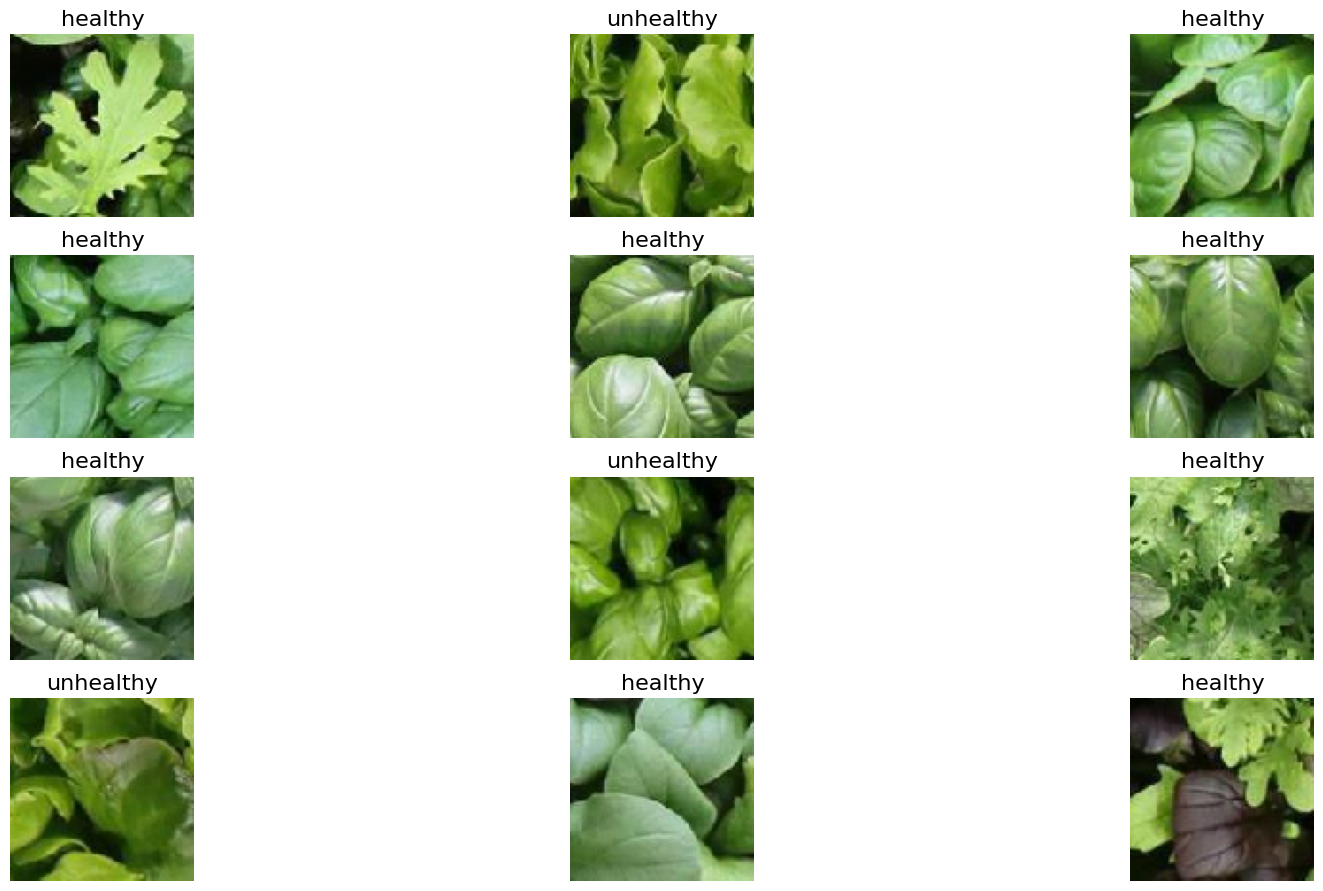

In [4]:
num_img = 12
amountOfRow = 4

images = (dataset['data'] / 255).astype(np.float32)
width = height = dataset['data'][0].shape[0]

fig, axes = plt.subplots(amountOfRow, num_img//amountOfRow, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%amountOfRow, i%num_img//amountOfRow]
    ax.imshow(images[i])  # Display clipped item images
    ax.text(width/2,-5,dataset['labels'][i],fontsize=16, ha='center')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
unique_labels = np.unique(dataset['labels'])
label_to_int = {label: index for index, label in enumerate(unique_labels)}
label_to_int
desired_output = [label_to_int[lab] for lab in dataset['labels']]

LabelDataFrame = pd.DataFrame(dataset['labels'])
intDataFrame = pd.DataFrame(desired_output)

print(f"Original labels count: {LabelDataFrame.value_counts()}")
print(f"Integer labels count: {intDataFrame.value_counts()}")

Original labels count: 0        
healthy      3199
unhealthy    2001
Name: count, dtype: int64
Integer labels count: 0
0    3199
1    2001
Name: count, dtype: int64


In [6]:
# Images from the dataset
X = images

# Create labels: 1 for 'unhealthy', 0 for 'healty'
y = intDataFrame

y = tfk.utils.to_categorical(y,len(np.unique(y)))

#Cleaning this shit out
target_value1 = images[506] #shrek

target_value2 = images[529] #trololo

# Create a boolean mask that checks for equality with the target image
mask = np.all(images == target_value1, axis=(1, 2, 3))

# Use the mask to filter the original array and remove matching instances
filtered_array = images[~mask]

matching_indices = np.where(mask)[0]
filtered_labels = y[~mask]

# Create a boolean mask that checks for equality with the target image
mask2 = np.all(filtered_array == target_value2, axis=(1, 2, 3))

# Use the mask to filter the original array and remove matching instances
filtered_array = filtered_array[~mask2]
filtered_labels = filtered_labels[~mask2]

print("Original array shape:", images.shape)
print("Filtered array shape:", filtered_array.shape)
print("Filtered labels shape:", filtered_labels.shape)

X = filtered_array
y = filtered_labels

#End  of Cleaning this shit out

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.20, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print(f"X_test dtype: {X_test.dtype}, y_test dtype: {y_test.dtype}")

Original array shape: (5200, 96, 96, 3)
Filtered array shape: (5004, 96, 96, 3)
Filtered labels shape: (5004, 2)
X_train shape: (3002, 96, 96, 3), y_train shape: (3002, 2)
X_val shape: (1001, 96, 96, 3), y_val shape: (1001, 2)
X_test shape: (1001, 96, 96, 3), y_test shape: (1001, 2)
X_test dtype: float32, y_test dtype: float64


In [7]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 1000

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")


Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 1000


**HYPERPARAMETERS**

In [8]:
dropout_rate = 0.4
learning_rate_transfer_learning_phase = 1e-4
learning_rate_fine_tuning_phase = 5e-5
weight_decay_transfer_learning_phase=7e-4
weight_decay_fine_tuning_phase = 3e-4
percentage_of_locked_layer_in_fine_tuning = 0.65

doubleLayerInClassification=True
secondLayerUnits = 128

**BUILD THE MODEL**

In [9]:
def build_Model(input_shape,output_shape=2,dropout=0.5,learning_rate=learning_rate_transfer_learning_phase,weight_decay=weight_decay_transfer_learning_phase):

  preprocessing = tf.keras.Sequential([
        tfkl.RandomTranslation(0.1,0.1),
        tfkl.RandomZoom(0.05),
        tfkl.RandomRotation(0.2),
        tfkl.RandomFlip("horizontal"),
        #tfkl.RandAugment(
        #  value_range=(0,255),
        #  augmentations_per_image=3,
        #  magnitude=0.5,
        #  magnitude_stddev=0.15,
        #  rate=0.9090909090909091,
        #  geometric=True,
        #  seed=None
        #)
        #tf.keras.layers.Rescaling(1./127.5, offset=-1), # To be used for nets which require input to be in range [-1 , 1]
        #tf.keras.layers.Rescaling(1./255), # To be used for nets which require input to be in range [0 , 1]
    ], name='preprocessing')


  importedNet = tf.keras.applications.EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg",
  )

  importedNet.trainable = False

  inputs = tfk.Input(shape=input_shape)

  preprocessing = preprocessing(inputs)

  x = importedNet(preprocessing)

  if doubleLayerInClassification:
    if dropout_rate != 0:
      x = tfkl.Dropout(dropout)(x)
    x = tfkl.Dense(secondLayerUnits, activation="relu")(x)

  if dropout_rate != 0:
    x = tfkl.Dropout(dropout)(x)
  outputs = tfkl.Dense(output_shape, activation="softmax")(x)

  model = tfk.Model(inputs=inputs,outputs = outputs)

  model.compile(loss = tfk.losses.CategoricalCrossentropy(),optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate,weight_decay=weight_decay,amsgrad=True),metrics=['accuracy'])
  #inceptionModel.compile(loss = tfk.losses.CategoricalCrossentropy(),optimizer=tfk.optimizers.Adam(),metrics=['accuracy'])


  model.summary()

  return model


In [10]:
myModel = build_Model(input_shape=input_shape,weight_decay=weight_decay_transfer_learning_phase,learning_rate=learning_rate_transfer_learning_phase,dropout=dropout_rate)

2024-03-28 19:06:37.599312: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 19:06:37.694686: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 19:06:37.694727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 19:06:37.696839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-28 19:06:37.696873: I external/local_xla/xla/stream_executor

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Sequential)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,127,616 (50.08 MB)

 Trainable params: 196,994 (769.51 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [11]:
# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')
]

# Print the defined callbacks
print("Callbacks:")
for callback in callbacks:
    print(callback)

Callbacks:


In [12]:
# Train the model
myHistory = myModel.fit(
    x = (X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val*255, y_val),
    callbacks = callbacks
).history

Epoch 1/1000


2024-03-28 19:06:49.361809: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.5755 - loss: 0.7186 - val_accuracy: 0.6503 - val_loss: 0.5990 - learning_rate: 1.0000e-04
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6505 - loss: 0.6255 - val_accuracy: 0.7313 - val_loss: 0.5617 - learning_rate: 1.0000e-04
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6754 - loss: 0.6034 - val_accuracy: 0.7453 - val_loss: 0.5400 - learning_rate: 1.0000e-04
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7125 - loss: 0.5639 - val_accuracy: 0.7522 - val_loss: 0.5196 - learning_rate: 1.0000e-04
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6870 - loss: 0.5884 - val_accuracy: 0.7852 - val_loss: 0.5069 - learning_rate: 1.0000e-04
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7231 - loss: 0.5550 - val_accuracy: 0.7592 - val_loss: 0.4996 - learning_rate: 1.0000e-04
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.734

In [13]:
test_predictions = myModel.predict(X_test*255, verbose=0)


In [15]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

print('Accuracy:', round(accuracy,4))
print('Precision:', round(precision,4))
print('Recall:', round(recall,4))
print('F1:', round(f1,4))

Accuracy: 0.8462
Precision: 0.8443
Recall: 0.8252
F1: 0.8326


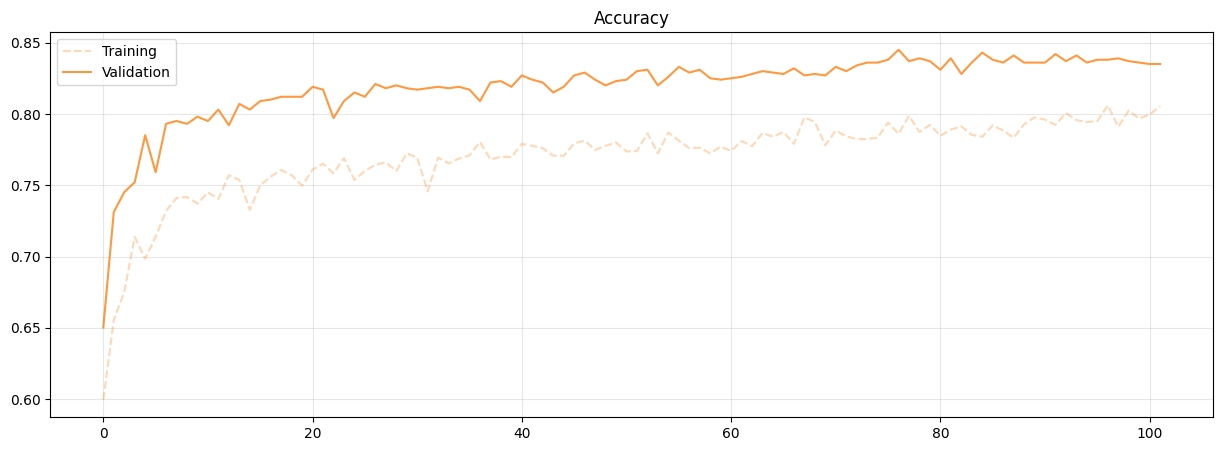

In [16]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(myHistory['accuracy'], label="Training",alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(myHistory['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.show()

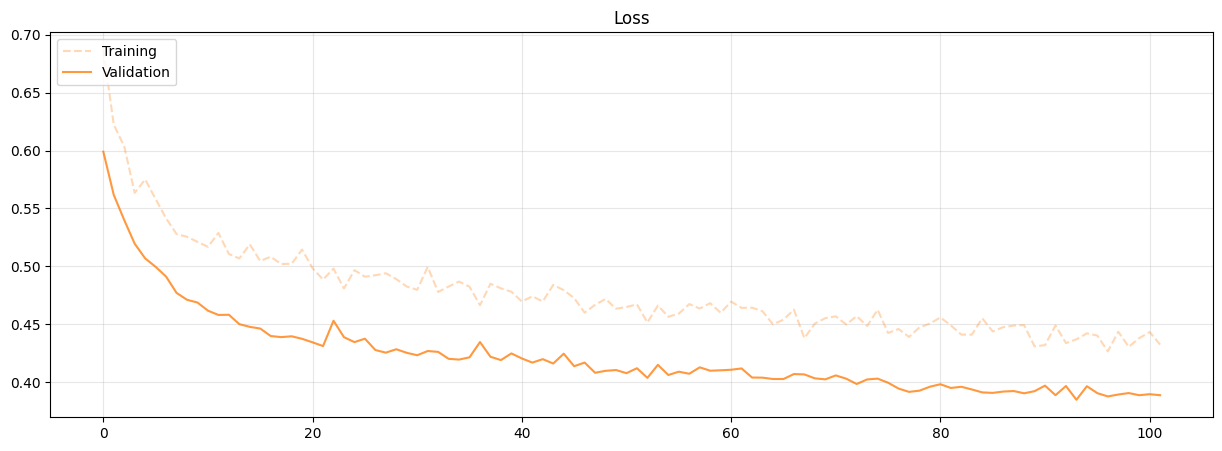

In [17]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(myHistory['loss'], label="Training",alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(myHistory['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)
plt.show()

**Fine Tuning**

In [18]:
for layer in myModel.layers:
  layer.trainable = True

In [21]:
importedNetLayer = myModel.get_layer("efficientnetv2-b3")

totLevelsInImportedNet = len(importedNetLayer.layers)

locked = int(percentage_of_locked_layer_in_fine_tuning * totLevelsInImportedNet)
unlocked = totLevelsInImportedNet - locked

for layer in importedNetLayer.layers[0:locked]:
  layer.trainable = False

for layer in importedNetLayer.layers[unlocked:]:
  layer.trainable = True



In [22]:
myModel.compile(loss = tfk.losses.CategoricalCrossentropy(),optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate_fine_tuning_phase,weight_decay=weight_decay_fine_tuning_phase),metrics=['accuracy'])


In [23]:
myModel.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Sequential)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 1536)           │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,127,616 (50.08 MB)

 Trainable params: 11,638,622 (44.40 MB)

 Non-trainable params: 1,488,994 (5.68 MB)

In [24]:
# Train the model
myHistoryFT = myModel.fit(
    x = (X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val*255, y_val), # We need to apply the preprocessing thought for the original network
    callbacks = callbacks
).history

Epoch 1/1000


2024-03-28 19:14:27.694692: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetv2-b3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 108ms/step - accuracy: 0.5945 - loss: 0.8444 - val_accuracy: 0.7303 - val_loss: 0.5456 - learning_rate: 5.0000e-05
Epoch 2/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.6938 - loss: 0.6473 - val_accuracy: 0.7882 - val_loss: 0.4708 - learning_rate: 5.0000e-05
Epoch 3/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.7190 - loss: 0.5758 - val_accuracy: 0.7962 - val_loss: 0.4490 - learning_rate: 5.0000e-05
Epoch 4/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.7443 - loss: 0.5432 - val_accuracy: 0.8052 - val_loss: 0.4332 - learning_rate: 5.0000e-05
Epoch 5/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.7674 - loss: 0.5051 - val_accuracy: 0.8052 - val_loss: 0.4224 - learning_rate: 5.0000e-05
Epoch 6/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.7692 - loss: 0.4926 - val_accuracy: 0.8112 - val_loss: 0.4032 - learning_rate: 5.0000e-05
Epoch 7/1000
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.79

In [25]:
test_predictionsFT = myModel.predict(X_test*255, verbose=0)


In [26]:
accuracyFT = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictionsFT, axis=-1))
precisionFT = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictionsFT, axis=-1), average='macro')
recallFT = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictionsFT, axis=-1), average='macro')
f1FT = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictionsFT, axis=-1), average='macro')

print('Accuracy:', round(accuracyFT,4))
print('Precision:', round(precisionFT,4))
print('Recall:', round(recallFT,4))
print('F1:', round(f1FT,4))

Accuracy: 0.9001
Precision: 0.8986
Recall: 0.888
F1: 0.8927


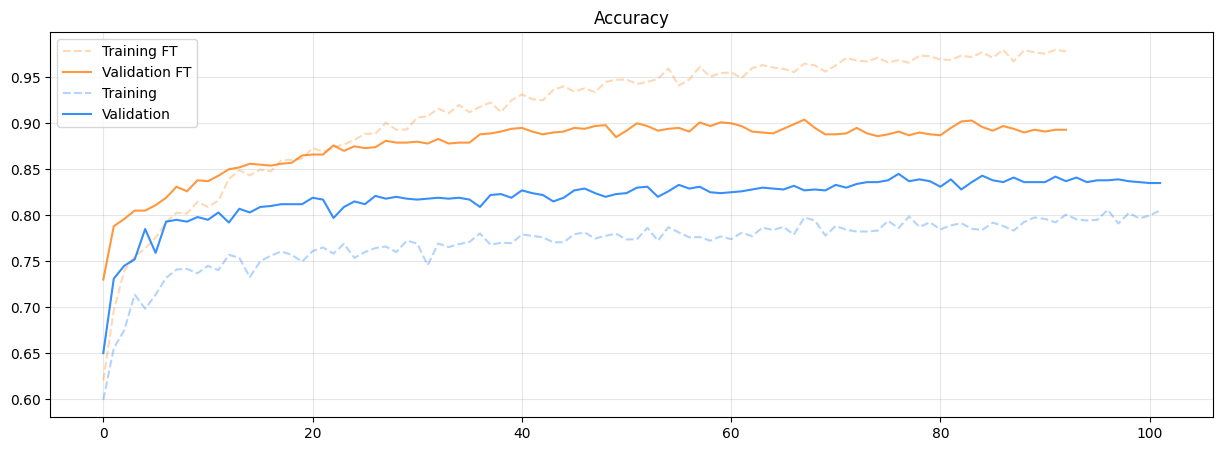

In [32]:
# Plot the re-trained and the transfer learning training histories
plt.figure(figsize=(15,5))
plt.plot(myHistoryFT['accuracy'], label="Training FT",alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(myHistoryFT['val_accuracy'], label='Validation FT', alpha=.8, color='#ff7f0e')
plt.plot(myHistory['accuracy'], label="Training",alpha=.3, color='#0373fc', linestyle='--')
plt.plot(myHistory['val_accuracy'], label='Validation', alpha=.8, color='#0373fc')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.show()

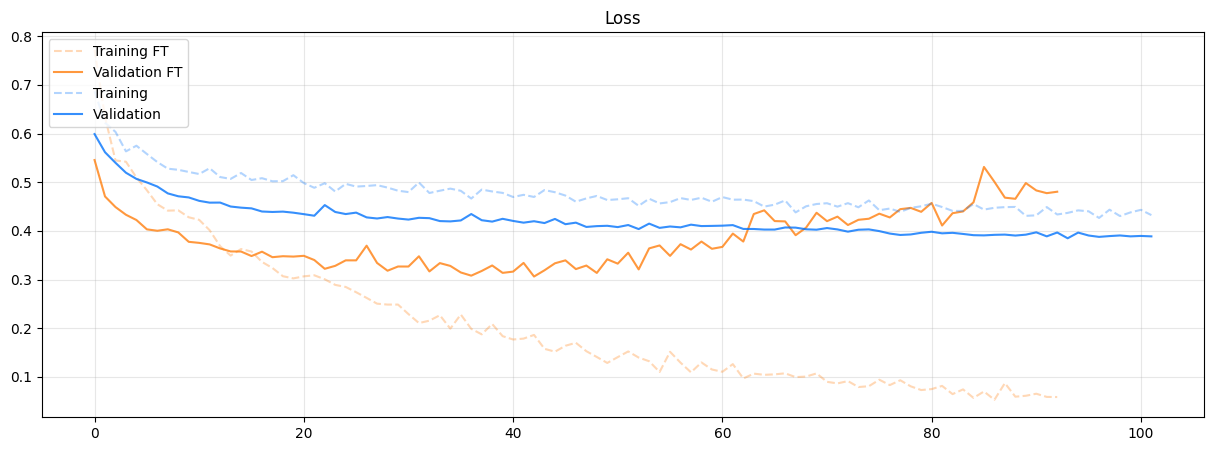

In [33]:
# Plot the re-trained and the transfer learning training histories
plt.figure(figsize=(15,5))
plt.plot(myHistoryFT['loss'], label="Training FT",alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(myHistoryFT['val_loss'], label='Validation FT', alpha=.8, color='#ff7f0e')
plt.plot(myHistory['loss'], label="Training",alpha=.3, color='#0373fc', linestyle='--')
plt.plot(myHistory['val_loss'], label='Validation', alpha=.8, color='#0373fc')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)
plt.show()

In [30]:
myModel.save('B3_FineTuned_Transformations.keras')

In [31]:
del myModel